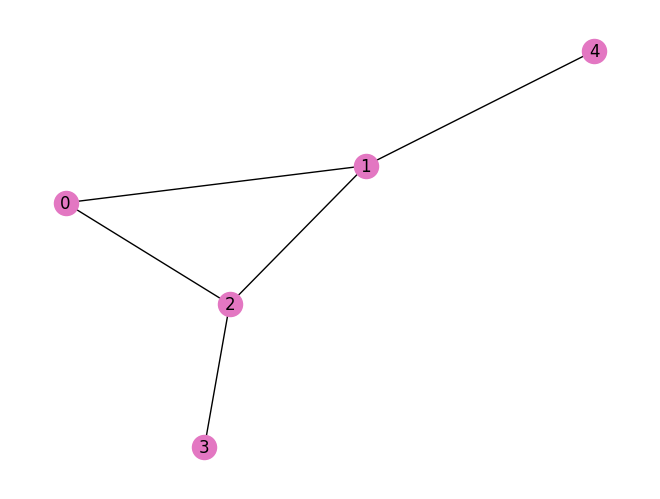

Cost Hamiltonian
0.75 * (Z(0) @ Z(3)) + -0.75 * Z(0) + -0.75 * Z(3) + 0.75 * (Z(0) @ Z(4)) + -0.75 * Z(0) + -0.75 * Z(4) + 0.75 * (Z(1) @ Z(3)) + -0.75 * Z(1) + -0.75 * Z(3) + 0.75 * (Z(2) @ Z(4)) + -0.75 * Z(2) + -0.75 * Z(4) + 0.75 * (Z(3) @ Z(4)) + -0.75 * Z(3) + -0.75 * Z(4) + 1.0 * Z(0) + 1.0 * Z(1) + 1.0 * Z(2) + 1.0 * Z(3) + 1.0 * Z(4)
Driver Hamiltonian
1 * X(0) + 1 * X(1) + 1 * X(2) + 1 * X(3) + 1 * X(4)
MaxClique Commutator
1.0 * 6 * (Y(0) @ Z(3) + -1 * Y(0)) + 1.0 * 6 * (Y(0) @ Z(4) + -1 * Y(0)) + 1.0 * 6 * Y(0) + 1.0 * 6 * (Y(1) @ Z(3) + -1 * Y(1)) + 1.0 * 6 * Y(1) + 1.0 * 6 * (Y(2) @ Z(4) + -1 * Y(2)) + 1.0 * 6 * Y(2) + 1.0 * 6 * (Z(0) @ Y(3) + -1 * Y(3)) + 1.0 * 6 * (Z(1) @ Y(3) + -1 * Y(3)) + 1.0 * 6 * (Y(3) @ Z(4) + -1 * Y(3)) + 1.0 * 6 * Y(3) + 1.0 * 6 * (Z(0) @ Y(4) + -1 * Y(4)) + 1.0 * 6 * (Z(2) @ Y(4) + -1 * Y(4)) + 1.0 * 6 * (Z(3) @ Y(4) + -1 * Y(4)) + 1.0 * 6 * Y(4)
-0.28775231023558545
-0.803506834310231
-1.0070300078852654
-1.0724333934255337
-1.1494140129588362

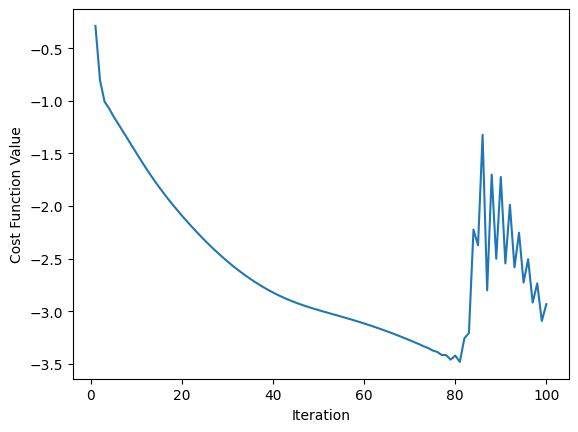

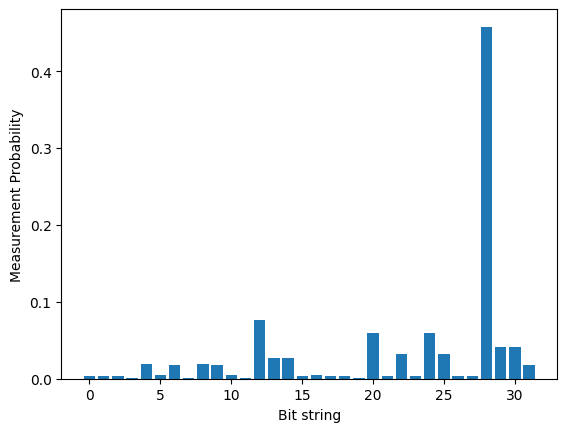

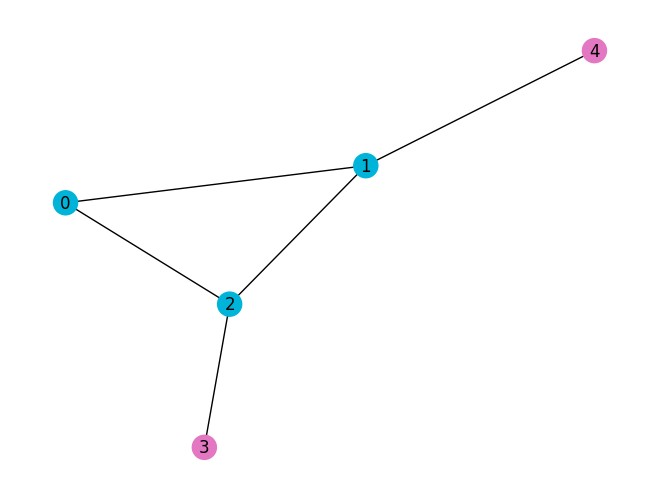

In [4]:
import pennylane as qml
from pennylane import numpy as np
from matplotlib import pyplot as plt
from pennylane import qaoa as qaoa
import networkx as nx

edges = [(0, 1), (1, 2), (2, 0), (2, 3), (1, 4)] #Defines the list of edges that will make up the graph. Each pair has a connection between two nodes.
graph = nx.Graph(edges) #Creates an undirected graph (Graph) object from the given edge list using NetworkX.   undirected graph :A to B, B to A
positions = nx.spring_layout(graph, seed=1) #Calculates the layout (node positions) using the spring layout algorithm.Set Random seed=1 ensures consistent layout every time.
nx.draw(graph, with_labels=True, node_color="#e377c2", pos=positions) #show node labels,set node color to pink,use the previously calculated layout
plt.show()

cost_h, driver_h = qaoa.max_clique(graph, constrained=False)

print("Cost Hamiltonian")
print(cost_h)
print("Driver Hamiltonian")
print(driver_h)

#the code here is trying to compute commutator
def build_hamiltonian(graph): #builds a Hamiltonian from a given graph
    H = qml.Hamiltonian([], []) #initialize an empty Hamiltonian object in PennyLane to store the terms.

    graph_c = nx.complement(graph) # Computes the complement of the inpput graph,this represents qubit pairs that are not connected in the original graph

    for k in graph_c.nodes: #Iterate over each node k in the graph,which represents a qubit

        for edge in graph_c.edges: #Iterate over each edge (i,j) in the complement graph,representing a non-adjacent qubit pair
            i, j = edge
            if k == i:
                H += 6 * (qml.PauliY(k) @ qml.PauliZ(j) - qml.PauliY(k)) #according to the formula
            if k == j:
                H += 6 * (qml.PauliZ(i) @ qml.PauliY(k) - qml.PauliY(k))
        # Adds the terms in the second sum
        H += 6 * qml.PauliY(k)

    return H


print("MaxClique Commutator")
print(build_hamiltonian(graph))

def falqon_layer(beta_k, cost_h, driver_h, delta_t): #representing one layer of Trotterized evolution in FALQON
    qml.ApproxTimeEvolution(cost_h, delta_t, 1) # applies time evolution under the cost Hamiltonian H_c for time delta t
    qml.ApproxTimeEvolution(driver_h, delta_t * beta_k, 1) #applies time evolution under the driver Hamiltonian H_d,scaled by feedback factor beta_k

def build_maxclique_ansatz(cost_h, driver_h, delta_t): #Define a method to construct the ansatz circuit for solving the MaxClique problem
    def ansatz(beta, **kwargs): #Inside it define a function that takes a list of feedback parameters beta
        layers = len(beta) #Use the length of beta to determine the number of evolution layers
        for w in dev.wires:
            qml.Hadamard(wires=w) #Apply Hadamard gates to all qubits to prepare the uniform superposition initial state.
        qml.layer( #Apply the falqon_layer function in a loop,using each beta_k along with H_c,H_d and time delta_t
            falqon_layer,
            layers,
            beta,
            cost_h=cost_h,
            driver_h=driver_h,
            delta_t=delta_t
        )

    return ansatz #return the ansatz function for use in the quantum circuit.


def expval_circuit(beta, measurement_h): #run the circuit and returns an expectation value.
    ansatz = build_maxclique_ansatz(cost_h, driver_h, delta_t) #Construct the ansatz using the cost and driver Hamiltonians.
    ansatz(beta)  #apply the ansatz to the circuit using feedback parameters beta
    return qml.expval(measurement_h) #return the expecatation value of the specified measurement Hamiltonian.


def max_clique_falqon(graph, n, beta_1, delta_t, dev): #define the main function,which runs the FALQON algorithm for the MaxClique problem.
    comm_h = build_hamiltonian(graph) # Builds the commutator 【H_d,H_c】,which is used to generate the next feedback parameter beta_k.
    cost_h, driver_h = qaoa.max_clique(graph, constrained=False) # use QAOA utilities to Builds H_c and H_d
    cost_fn = qml.QNode(expval_circuit, dev, interface="autograd") # Wrap expval_circuit into a QNode to create an executable quantum circuit that returns expectation values.

    beta = [beta_1] # Records each value of beta_k,initialize the list of beta values(starting with beta_1)
    energies = [] # an empty list for Records the value of the cost function at each step

    for i in range(n): #Loop over n layers,each step ganerates and applies a new feedback parameter
        # Adds a value of beta to the list and evaluates the cost function
        next_beta = -1 * cost_fn(beta, measurement_h=comm_h)
        beta.append(next_beta)  # this call measures the expectation of the commutator Hamiltonian and multiply by -1 to obtain the next beta_k.
        energy = cost_fn(beta, measurement_h=cost_h)  # this call measures the expectation of the cost hamiltonian,using the current beta sequence.
        energies.append(energy) #append the current energy value to the "energies" list
        print(energy)
    return beta, energies #return the full list of feedback parameters beta_k and the corresponding cost function values.


n = 100
beta_1 = 0.0
delta_t = 0.03

dev = qml.device("default.qubit", wires=graph.nodes) # Creates a quantum device using the "default.qubit" simulator,with the number of qubits equal to the number of graph nodes.
res_beta, res_energies = max_clique_falqon(graph, n, beta_1, delta_t, dev) #run the FALQON algorithm on the given graph using the parameters,and get back the list of beta values and energy at each step.


plt.plot(range(n+1)[1:], res_energies)
plt.xlabel("Iteration")
plt.ylabel("Cost Function Value")
plt.show()

@qml.qnode(dev, interface="autograd") #this line wraps the "prob_circuit" function into a QNode,runs it on the "dev" device, and uses the "autograd" interface for differentiation
def prob_circuit(): #to compute measurement probabilities
    ansatz = build_maxclique_ansatz(cost_h, driver_h, delta_t) #use the "build_maxclique_ansatz" function to construct the parameterized quamtum circuit for the MaxClique problem
    ansatz(res_beta) #Apply the optimized feedback parameters "res_beta" to build the final evolved quantum state
    return qml.probs(wires=dev.wires) #return the probabilities of all possible bitstrings over qubits 


probs = prob_circuit()
plt.bar(range(2**len(dev.wires)), probs)
plt.xlabel("Bit string")
plt.ylabel("Measurement Probability")
plt.show()


graph = nx.Graph(edges)
cmap = ["#00b4d9"]*3 + ["#e377c2"]*2
positions = nx.spring_layout(graph, seed=1)
nx.draw(graph, with_labels=True, node_color=cmap, pos=positions)
plt.show()